Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
> layers=2, train=0.822, test=0.834
> layers=3, train=0.834, test=0.828
> layers=4, train=0.836, test=0.832
> layers=5, train=0.838, test=0.832
> layers=6, train=0.844, test=0.828
> layers=7, train=0.842, test=0.834
> layers=8, train=0.836, test=0.828
> layers=9, train=0.842, test=0.830
> layers=10, train=0.836, test=0.824
> layers=11, train=0.842, test=0.830
> layers=12, train=0.848, test=0.826


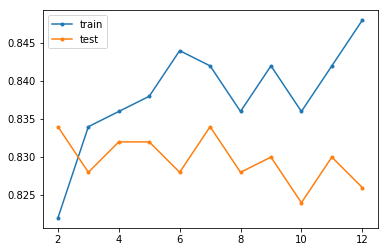

In [1]:
# supervised greedy layer-wise pretraining for blobs classification problem
from sklearn.datasets.samples_generator import make_blobs
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import to_categorical
from matplotlib import pyplot

# prepare the dataset
def prepare_data():
	# generate 2d classification dataset
	X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)
	# one hot encode output variable
	y = to_categorical(y)
	# split into train and test
	n_train = 500
	trainX, testX = X[:n_train, :], X[n_train:, :]
	trainy, testy = y[:n_train], y[n_train:]
	return trainX, testX, trainy, testy

# define and fit the base model
def get_base_model(trainX, trainy):
	# define model
	model = Sequential()
	model.add(Dense(10, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(3, activation='softmax'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
	# fit model
	model.fit(trainX, trainy, epochs=100, verbose=0)
	return model

# evaluate a fit model
def evaluate_model(model, trainX, testX, trainy, testy):
	_, train_acc = model.evaluate(trainX, trainy, verbose=0)
	_, test_acc = model.evaluate(testX, testy, verbose=0)
	return train_acc, test_acc

# add one new layer and re-train only the new layer
def add_layer(model, trainX, trainy):
	# remember the current output layer
	output_layer = model.layers[-1]
	# remove the output layer
	model.pop()
	# mark all remaining layers as non-trainable
	for layer in model.layers:
		layer.trainable = False
	# add a new hidden layer
	model.add(Dense(10, activation='relu', kernel_initializer='he_uniform'))
	# re-add the output layer
	model.add(output_layer)
	# fit model
	model.fit(trainX, trainy, epochs=100, verbose=0)

# prepare data
trainX, testX, trainy, testy = prepare_data()
# get the base model
model = get_base_model(trainX, trainy)
# evaluate the base model
scores = dict()
train_acc, test_acc = evaluate_model(model, trainX, testX, trainy, testy)
print('> layers=%d, train=%.3f, test=%.3f' % (len(model.layers), train_acc, test_acc))
scores[len(model.layers)] = (train_acc, test_acc)
# add layers and evaluate the updated model
n_layers = 10
for i in range(n_layers):
	# add layer
	add_layer(model, trainX, trainy)
	# evaluate model
	train_acc, test_acc = evaluate_model(model, trainX, testX, trainy, testy)
	print('> layers=%d, train=%.3f, test=%.3f' % (len(model.layers), train_acc, test_acc))
	# store scores for plotting
	scores[len(model.layers)] = (train_acc, test_acc)
# plot number of added layers vs accuracy
pyplot.plot(scores.keys(), [scores[k][0] for k in scores.keys()], label='train', marker='.')
pyplot.plot(scores.keys(), [scores[k][1] for k in scores.keys()], label='test', marker='.')
pyplot.legend()
pyplot.show()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
> reconstruction error train=0.000, test=0.000
> classifier accuracy layers=2, train=0.816, test=0.834
> reconstruction error train=0.003, test=0.006
> classifier accuracy layers=3, train=0.840, test=0.832
> reconstruction error train=0.003, test=0.008
> classifier accuracy layers=4, train=0.832, test=0.838
> reconstruction error train=0.004, test=0.010
> classifier accuracy layers=5, train=0.820, test=0.828
> reconstruction error train=0.003, test=0.009
> classifier accuracy layers=6, train=0.804, test=0.830
> reconstruction error train=0.008, test=0.014
> classifier accuracy layers=7, train=0.824, test=0.826


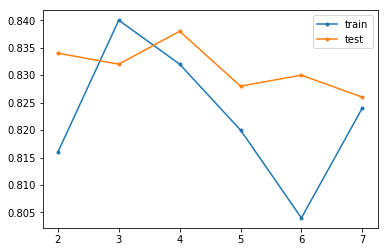

In [1]:
# unsupervised greedy layer-wise pretraining for blobs classification problem
from sklearn.datasets.samples_generator import make_blobs
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import to_categorical
from matplotlib import pyplot

# prepare the dataset
def prepare_data():
	# generate 2d classification dataset
	X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)
	# one hot encode output variable
	y = to_categorical(y)
	# split into train and test
	n_train = 500
	trainX, testX = X[:n_train, :], X[n_train:, :]
	trainy, testy = y[:n_train], y[n_train:]
	return trainX, testX, trainy, testy

# define, fit and evaluate the base autoencoder
def base_autoencoder(trainX, testX):
	# define model
	model = Sequential()
	model.add(Dense(10, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(2, activation='linear'))
	# compile model
	model.compile(loss='mse', optimizer=SGD(lr=0.01, momentum=0.9))
	# fit model
	model.fit(trainX, trainX, epochs=100, verbose=0)
	# evaluate reconstruction loss
	train_mse = model.evaluate(trainX, trainX, verbose=0)
	test_mse = model.evaluate(testX, testX, verbose=0)
	print('> reconstruction error train=%.3f, test=%.3f' % (train_mse, test_mse))
	return model

# evaluate the autoencoder as a classifier
def evaluate_autoencoder_as_classifier(model, trainX, trainy, testX, testy):
	# remember the current output layer
	output_layer = model.layers[-1]
	# remove the output layer
	model.pop()
	# mark all remaining layers as non-trainable
	for layer in model.layers:
		layer.trainable = False
	# add new output layer
	model.add(Dense(3, activation='softmax'))
	# compile model
	model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01, momentum=0.9), metrics=['acc'])
	# fit model
	model.fit(trainX, trainy, epochs=100, verbose=0)
	# evaluate model
	_, train_acc = model.evaluate(trainX, trainy, verbose=0)
	_, test_acc = model.evaluate(testX, testy, verbose=0)
	# put the model back together
	model.pop()
	model.add(output_layer)
	model.compile(loss='mse', optimizer=SGD(lr=0.01, momentum=0.9))
	return train_acc, test_acc

# add one new layer and re-train only the new layer
def add_layer_to_autoencoder(model, trainX, testX):
	# remember the current output layer
	output_layer = model.layers[-1]
	# remove the output layer
	model.pop()
	# mark all remaining layers as non-trainable
	for layer in model.layers:
		layer.trainable = False
	# add a new hidden layer
	model.add(Dense(10, activation='relu', kernel_initializer='he_uniform'))
	# re-add the output layer
	model.add(output_layer)
	# fit model
	model.fit(trainX, trainX, epochs=100, verbose=0)
	# evaluate reconstruction loss
	train_mse = model.evaluate(trainX, trainX, verbose=0)
	test_mse = model.evaluate(testX, testX, verbose=0)
	print('> reconstruction error train=%.3f, test=%.3f' % (train_mse, test_mse))

# prepare data
trainX, testX, trainy, testy = prepare_data()
# get the base autoencoder
model = base_autoencoder(trainX, testX)
# evaluate the base model
scores = dict()
train_acc, test_acc = evaluate_autoencoder_as_classifier(model, trainX, trainy, testX, testy)
print('> classifier accuracy layers=%d, train=%.3f, test=%.3f' % (len(model.layers), train_acc, test_acc))
scores[len(model.layers)] = (train_acc, test_acc)
# add layers and evaluate the updated model
n_layers = 5
for _ in range(n_layers):
	# add layer
	add_layer_to_autoencoder(model, trainX, testX)
	# evaluate model
	train_acc, test_acc = evaluate_autoencoder_as_classifier(model, trainX, trainy, testX, testy)
	print('> classifier accuracy layers=%d, train=%.3f, test=%.3f' % (len(model.layers), train_acc, test_acc))
	# store scores for plotting
	scores[len(model.layers)] = (train_acc, test_acc)
# plot number of added layers vs accuracy
keys = scores.keys()
pyplot.plot(keys, [scores[k][0] for k in keys], label='train', marker='.')
pyplot.plot(keys, [scores[k][1] for k in keys], label='test', marker='.')
pyplot.legend()
pyplot.show()